In [1]:
# SOURCE: https://notebooks.azure.com/Microsoft/libraries/samples/html/Creation%20and%20Deployment%20of%20an%20Azure%20ML%20Web%20Service.ipynb
import azureml
workspace_id        = '349a3113216c4cdfbd02670191cf74c3'
authorization_token = 'a1e29ba6b8cd4fdd82a0df4bd8c7a8ad'
ws                  = azureml.Workspace(workspace_id, authorization_token)

In [2]:
!pip install pydataset --disable-pip-version-check -q
import pandas as pd
from pydataset import data

In [3]:
# time  : Time of day when recording was made
# activ : Binary indicator of whether activity is occurring outside of the beaver lodge
# beaver: Beaver being measured
# temp  : Recorded body temperature

df           = data('beav1')
df['beaver'] = 1
# Merging / Concat: https://pandas.pydata.org/pandas-docs/stable/merging.html
df           = pd.concat([df, data('beav2')])
df.loc[df['beaver'].isnull(), 'beaver'] = 2
# Return new object with labels in requested axis removed.
df.drop('day', 1, inplace=True)

/home/nbuser/anaconda2_410/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


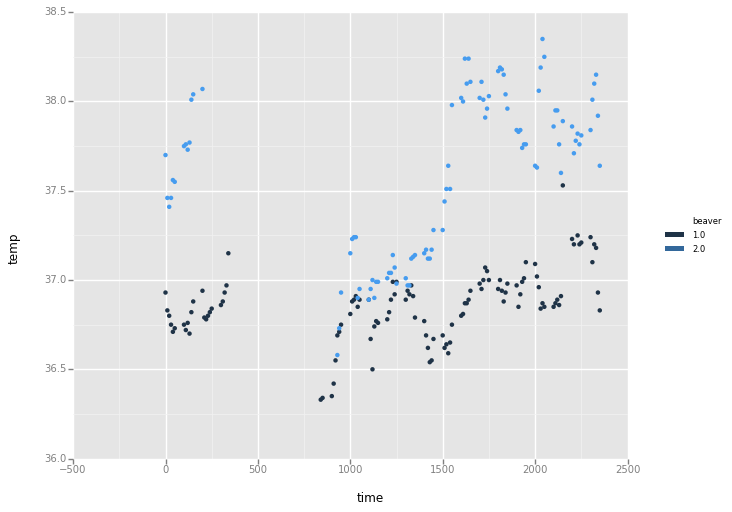

<ggplot: (8756344324269)>

In [4]:
%matplotlib inline
from ggplot import *
ggplot(aes(x='time', y='temp', color='beaver'), data=df) + geom_point()

In [5]:
# Transfers data to Azure ML studio & create predicitive model.
# If data already exists, will throw:-- AzureMLConflictHttpError --

# dataset = ws.datasets.add_from_dataframe(dataframe   =df,
#                                         data_type_id=azureml.DataTypeIds.GenericCSV,
#                                         name        ='Beaver Body Temperature Data',
#                                         description ='From Reynolds 1994 via pydataset')

In [6]:
# List user-created datasets from my Azure ML sub
print('\n'.join([i.name for i in ws.datasets if not i.is_example])) 

Gender Model
Candidate Committee Linkage
Committee List
US Candidate List
UCI German Credit Card Data
FlightData.csv
BigFlightData.csv
Beaver Body Temperature Data


In [7]:
# Read some more of the metadata
ds = ws.datasets['Beaver Body Temperature Data']
print(ds.name)
print(ds.description)
print(ds.family_id)
print(ds.data_type_id)
print(ds.created_date)
print(ds.size)

# Read the contents
df2 = ds.to_dataframe()
df2.head()

Beaver Body Temperature Data
From Reynolds 1994 via pydataset
9a22d89dafe14f6ab6bae8434e00901e
GenericCSV
2017-10-16 21:56:27.123000
3579


,activ,beaver,temp,time
0,0,1.0,36.33,840
1,0,1.0,36.34,850
2,0,1.0,36.35,900
3,0,1.0,36.42,910
4,0,1.0,36.55,920


In [8]:
# Deprication warning. Will be removed in 0.20
from sklearn.cross_validation import train_test_split

# Split arrays or matrices into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(df[['activ', 'beaver', 'time']],
                                                    df['temp'],
                                                    test_size=0.3,
                                                    random_state=42)

/home/nbuser/anaconda2_410/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
from sklearn.tree    import DecisionTreeRegressor
from sklearn.metrics import r2_score

# Trees:Used for classification and regression. A set of if-then-else decision rules. 
# PROS: Simple to understand and to interpret. Trees can be visualised. Little data prep.
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# coefficient of determination. Provides a measure of how well observed outcomes are replicated by the model.
y_test_predictions = regressor.predict(X_test)
print('R^2 for true vs. predicted test set temperature measurements: {:0.2f}'.format(r2_score(y_test, y_test_predictions)))

R^2 for true vs. predicted test set temperature measurements: 0.94


In [10]:
# Deploy as an azure ML service
from azureml import services
@services.publish(workspace_id, authorization_token)
@services.types(activ=int, beaver=float, time=int)
@services.returns(float)

# The name of your web service will be determined by this function's name
def beaver_body_temp_predictor(activ, beaver, time):
    return regressor.predict([activ, beaver, time])

# hold onto information about your web service so you can call it within the notebook later
service_url = beaver_body_temp_predictor.service.url 
api_key     = beaver_body_temp_predictor.service.api_key
help_url    = beaver_body_temp_predictor.service.help_url
service_id  = beaver_body_temp_predictor.service.service_id


In [12]:
# Consume the web service
beaver_body_temp_predictor.service(0, 1, 1200)

36.78

In [13]:
import urllib2
import json

# Make the request 
data = {"Inputs": {"input1": { "ColumnNames": [ "beaver", "activ", "time"],
                               "Values": [["1", "0", "1200"]] } }, # specified feature values
        "GlobalParameters": {} }
body    = json.dumps(data)
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}
req     = urllib2.Request(service_url, body, headers) 
try:
    response = urllib2.urlopen(req)
    result = json.loads(response.read())  # load json-formatted string response as dictionary
    print(result['Results']['output1']['value']['Values'][0][0]) # get the returned prediction
except urllib2.HTTPError, error:
    print("The request failed with status code: " + str(error.code))
    print(error.info())
    print(json.loads(error.read()))     

36.78
